### Responsible AI

_Understanding how AI leads to better decisions..._

This notebook seeks to mitigate the black box effect that comes with AI Models by rendering explanations into a model's decision process. This is done utilizing the SHAP python library.

This library is able to analyze relational effects features have on a models prediction. It achieves this through a number of permutation across all combination of features.

**Data Set Information:**
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

The code below is in python and the model library used is Scikit Learn



In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import shap

In [2]:
# Import dataset

filename = 'bank-additional-full.csv'
dataset_path = os.path.join('data', filename)

df = pd.read_csv(dataset_path, delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
# Identifying missing/null values

missing_values = df.isnull()
for cols in missing_values.columns:
    print(cols,': ', end="")
    print(missing_values[cols].value_counts())

age : False    41188
Name: age, dtype: int64
job : False    41188
Name: job, dtype: int64
marital : False    41188
Name: marital, dtype: int64
education : False    41188
Name: education, dtype: int64
default : False    41188
Name: default, dtype: int64
housing : False    41188
Name: housing, dtype: int64
loan : False    41188
Name: loan, dtype: int64
contact : False    41188
Name: contact, dtype: int64
month : False    41188
Name: month, dtype: int64
day_of_week : False    41188
Name: day_of_week, dtype: int64
duration : False    41188
Name: duration, dtype: int64
campaign : False    41188
Name: campaign, dtype: int64
pdays : False    41188
Name: pdays, dtype: int64
previous : False    41188
Name: previous, dtype: int64
poutcome : False    41188
Name: poutcome, dtype: int64
emp.var.rate : False    41188
Name: emp.var.rate, dtype: int64
cons.price.idx : False    41188
Name: cons.price.idx, dtype: int64
cons.conf.idx : False    41188
Name: cons.conf.idx, dtype: int64
euribor3m : False   

In [5]:
# Retrieving statistical summary

df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
# Display value counts for each categorical feature

def categorical_value_count(dataframe):
    column_list = dataframe.columns.tolist()
    for column in column_list:
        if dataframe[column].dtypes == 'object':
            print(dataframe[column].value_counts())
            print("")

categorical_value_count(df)

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

cellular     26144
telephone    15044
Name: contact, dtype: int64

may    13769
jul     7174
aug  

After looking through the dataset and its value distribution, the next will be to split the data into training and test set.

In [7]:
from sklearn.model_selection import train_test_split


# Getting the target variable
df_y = df.pop('y')

# Split data
x_train, x_test, y_train, y_test = train_test_split(df, df_y, test_size=0.2, random_state=21)

In [8]:
# defining categorical and numerical features from dataset using datatypes

def numeric_categoric(dataframe):
    """
    dataframe: A pandas dataframe
    return: Categorical Columns and Numeric Columns
    """

    cat_columns = []
    num_columns = []
    
    for cols in dataframe.columns.tolist():
        if dataframe[cols].dtypes == 'object':
            cat_columns.append(cols)
        else:
            num_columns.append(cols)
            
    return cat_columns, num_columns

cat_cols, num_cols = numeric_categoric(x_train)
print(cat_cols)
print()
print(num_cols)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


Data processing and model pipeline creation using Scikit Learn

In [9]:
numeric_pipeline = Pipeline(steps=[
    ('Scaler', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('Encoder', OneHotEncoder())
])

transformer = ColumnTransformer(transformers=[
    ('n', numeric_pipeline, num_cols),
    ('c', categorical_pipeline, cat_cols)
])

In [10]:
# Converting 'yes or no' in target feature to binary '0s and 1s'

def process_target(y):

    y_array = y.values
    y_array = y_array.reshape((len(y_array),1))
    ordinal = OrdinalEncoder()
    y_ordinal = ordinal.fit_transform(y_array)
    y_ordinal = y_ordinal.reshape((len(y),))
    y_ordinal[:10]

    return y_ordinal

y_train_processed = process_target(y_train)
y_test_processed = process_target(y_test)

In [11]:
transformer.fit(x_train)
x_train_new = transformer.transform(x_train)
x_test_new = transformer.transform(x_test)

In [12]:
feature_columns = transformer.get_feature_names_out().tolist()

In [13]:
# Extracting all feature names from pipeline

def strip_tag_transformer(column_list):
    cols_list = []
    for index in range(len(column_list)):
        cols_list.append(column_list[index][3:])

    return cols_list

features = strip_tag_transformer(feature_columns)

In [14]:
# Processed Dataframe ready for Model training

x_train_transform =  pd.DataFrame(x_train_new, columns=features)
x_test_transform = pd.DataFrame(x_test_new, columns=features)

x_train_transform.head(3)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0.283951,0.039108,0.036364,1.0,0.0,0.6875,0.389322,0.368201,0.780322,0.877883,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.419753,0.022032,0.000000,1.0,0.0,1.0000,0.484412,0.615063,0.981637,1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.358025,0.063068,0.000000,1.0,0.0,1.0000,0.484412,0.615063,0.981637,1.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Builing the Model

Setting up and training the model for a binary classification.

**Selected Model** The logistic regression is used in this case.

Model performance is also evaluated using the model accuracy, precision and recall.

Also a visualisation of the confusion matrix is provided/

In [15]:
lr = LogisticRegression(max_iter=1000).fit(x_train_transform, y_train_processed)

predictions = lr.predict(x_test_transform)

In [16]:
# Retrieving confusion matrix

cf_matrix = confusion_matrix(y_test_processed, predictions)

print("confusion Matrix: \n", cf_matrix, '\n')
print('Model Accuracy:', accuracy_score(y_test_processed, predictions))

confusion Matrix: 
 [[7123  189]
 [ 568  358]] 

Model Accuracy: 0.9081087642631707


<AxesSubplot:>

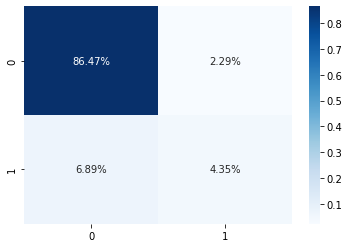

In [17]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues', fmt='.2%')

<AxesSubplot:>

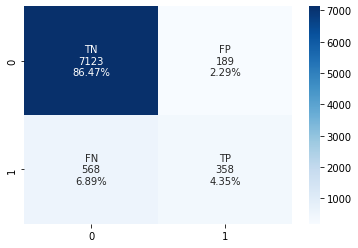

In [18]:
group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [30]:
print('recall: ', recall_score(y_true=y_test_processed, y_pred=predictions))
print('precision: ', precision_score(y_true=y_test_processed, y_pred=predictions))

recall:  0.38660907127429806
precision:  0.6544789762340036


In [27]:
lr.predict_proba(x_train_transform[1:2])

array([[0.99195722, 0.00804278]])

### Model Explanation

This section begins the use of the **SHAP** library to explain with visual representation how each feature participated in the outcome of the model's prediction.

In [30]:
# Instantiating the Explainer class from the SHAP library

explainer = shap.Explainer(lr.predict, x_train_transform)

Permutation explainer: 32951it [36:45, 14.86it/s]                           


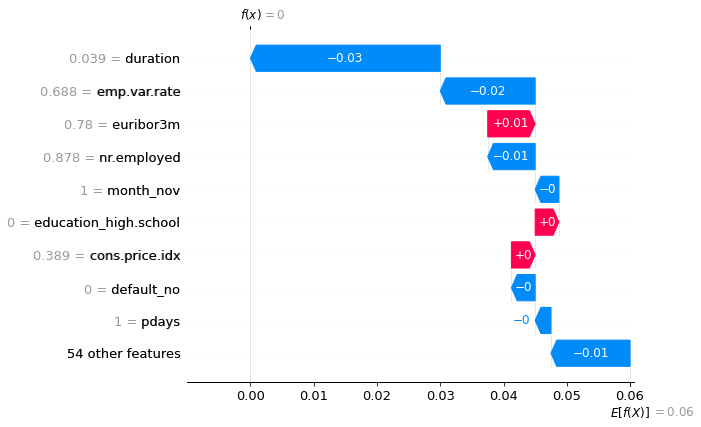

In [31]:
shap_values = explainer(x_train_transform)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

#### The WaterFall plot

This plot describes feature interaction of an instnace in the dataset as compared to the average prediction value.

This plot highlights major players in the prediction of the first instance from the training set.

<b> Duration, Employment Variation Rate, Euribor 3 month rate, Months etc. <b/>

These features listed above pose greater effect on the prediction compared to the others.

The Summary Plot gives an overview of the overall effect across all instances

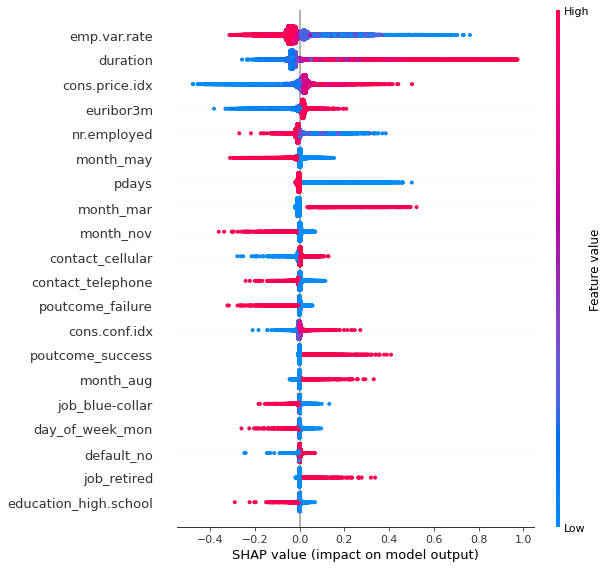

In [32]:
shap.summary_plot(shap_values)

### The Summary Plot

As shown in the previous plot for the first instance of the dataset, it is seen that the features that posed great effect for that instance also have equally strong effect on the general prediction.

The line running through the middle of the summary plot can be seen as the datum, and the blue colour for each feature indicates lower values of that feature. Hence, if a feature has a blue line, extending from the base or datum, then it indicates that lower values of that feature increases the effect it has on prediction. The reverse is the case for the red.

In [33]:
shap.initjs()
shap.force_plot(shap_values[0])

The force plot generally indicates the same relationship as the first two plots

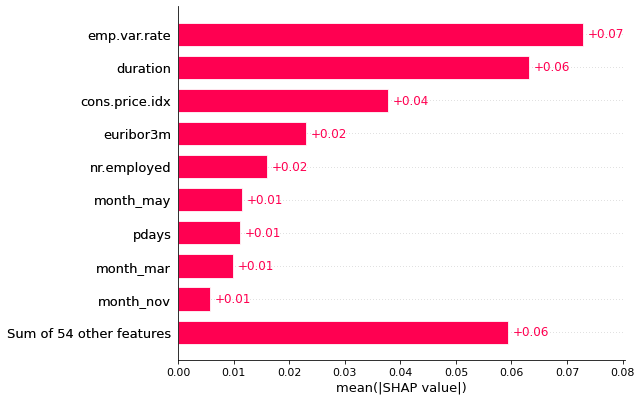

In [42]:
shap.plots.bar(shap_values)

### The Bar Plot

This represents the mean of the SHAP values across all features for all instances.
Again, We can still see the same set of features playing major roles in this chart.